In [1]:
# 한글 폰트 설정
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

print("한글 폰트 설치 완료!")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 0s (24.9 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126435 files and direc

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 깃허브 개발환경 세팅

In [2]:
# 1. 기존 리포지토리 폴더로 이동
import os
os.chdir('/content/drive/MyDrive/Codeit_AI_4th_Drug_image_CV_project')

In [3]:
# 2. 경로 확인
!pwd

/content/drive/MyDrive/Codeit_AI_4th_Drug_image_CV_project


In [4]:
# 3. 최신 변경사항 가져오기
!git pull origin main

remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 4 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Unpacking objects: 100% (4/4), 1.43 KiB | 2.00 KiB/s, done.
From https://github.com/Dongjin-1203/Codeit_AI_4th_Drug_image_CV_project
 * branch            main       -> FETCH_HEAD
   785c88a..d544061  main       -> origin/main
Updating 785c88a..d544061
Fast-forward
 daily_report/sample.md | 10 ++++++++++
 1 file changed, 10 insertions(+)
 create mode 100644 daily_report/sample.md


In [5]:
# 3. 현재 상태 확인
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   model/notebooks/ETL_test_YOLOv8.ipynb
	modified:   notebooks/data_EDA.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


# 코드잇 스프린트 초급 팀 프로젝트: 경구약제 이미지 객체 검출(Object Detection) 프로젝트

이 파일에서는 추후 전처리부터 모델 개발까지 일련의 과정에 핵심이 될 탐색적 데이터 탐색(EDA)를 진행할 예정이다.

## 데이터 탐색 요소
1. 폴더 구조 및 파일 개수 확인
2. JSON annotation 스키마 분석      
3. 이미지 데이터 분석
    - 이미지 해상도, 크기 분포
    - 이미지 품질 검사(손상된 파일, 노이즈 등)
    - 색상 분포 및 밝기 분석
    - 알약 형태별 분포
4. 라벨 데이터 분석
    - 클래스 분포 및 불균형 확인
    - 알약 종류별 통계
    - 제약회사별, 성분별 분포(판단 필요)
    - Missing value 및 이상치 탐지

한번에 실행하지 않고 단계별로 진행할 예정

## 1. 초기 세팅

In [22]:
import os
import json
import cv2
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
import random
import matplotlib.patches as patches
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

In [7]:
# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

## 2. 폴더 구조 및 파일 개수 분석

### 폴더 구조 및 파일 개수 확인

In [8]:
def check_dataset_structure(data_path):
    """데이터셋 기본 구조 확인"""
    data_path = Path(data_path)

    print("="*60)
    print("📁 데이터셋 구조 분석")
    print("="*60)

    if not data_path.exists():
        print(f"❌ 경로 없음: {data_path}")
        return {}

    results = {}

    # Train 이미지 확인
    train_img_path = data_path / "train_images"
    if train_img_path.exists():
        train_images = list(train_img_path.glob("*.png"))
        results['train_images'] = len(train_images)
        print(f"✅ Train 이미지: {len(train_images):,}개")

        # 파일명 패턴 분석
        if train_images:
            sample_names = [f.stem for f in train_images[:5]]
            print(f"📝 Train 파일명 샘플:")
            for name in sample_names:
                print(f"   {name}")
    else:
        results['train_images'] = 0
        print("❌ train_images 폴더 없음")

    # Test 이미지 확인
    test_img_path = data_path / "test_images"
    if test_img_path.exists():
        test_images = list(test_img_path.glob("*.png"))
        results['test_images'] = len(test_images)
        print(f"✅ Test 이미지: {len(test_images):,}개")
    else:
        results['test_images'] = 0
        print("❌ test_images 폴더 없음")

    # Annotation 폴더 구조 확인
    train_ann_path = data_path / "train_annotations"
    if train_ann_path.exists():
        print(f"✅ Train annotations 폴더 존재")

        # 하위 폴더 구조 탐색
        all_json_files = list(train_ann_path.glob("**/*.json"))
        results['train_annotations'] = len(all_json_files)
        print(f"📝 총 JSON 파일: {len(all_json_files):,}개")

        # 폴더 구조 분석
        subfolders = [d for d in train_ann_path.iterdir() if d.is_dir()]
        print(f"📂 Annotation 하위 폴더: {len(subfolders)}개")

        for subfolder in subfolders[:3]:  # 처음 3개만
            sub_subfolders = [d for d in subfolder.iterdir() if d.is_dir()]
            json_count = len(list(subfolder.glob("**/*.json")))
            print(f"   📁 {subfolder.name}/ ({len(sub_subfolders)}개 하위폴더, {json_count}개 JSON)")

        if len(subfolders) > 3:
            print(f"   ... 외 {len(subfolders)-3}개 폴더")

    else:
        results['train_annotations'] = 0
        print("❌ train_annotations 폴더 없음")

    return results

### 이미지 파일 속성 분석

In [9]:
def analyze_image_properties(data_path, sample_size=10):
    """이미지 해상도, 채널, 용량 등 속성 분석"""

    # 변수 설정
    data_path = Path(data_path)
    train_img_path = data_path / "train_images"
    test_img_path = data_path / "test_images"
    img_path_list = {"train": train_img_path, "test": test_img_path}

    # 1. 해상도 분포
    def find_image_size(image_path):
        try:
            # 이미지 열기
            image = Image.open(image_path)
            # 이미지 크기(해상도) 반환
            width, height = image.size
            return width, height
        except FileNotFoundError:
            print("이미지 파일을 찾을 수 없습니다.")
        except Exception as e:
            print("오류 발생:", e)

    # 너비, 높이 리스트 생성
    img_width_list = []
    img_height_list = []

    for img, img_path in img_path_list.items():
        # 각 타입별로 별도 리스트 생성
        current_width_list = []
        current_height_list = []

        if img_path.exists():
            img_files = list(img_path.glob("*.png"))

            # 먼저 모든 이미지 데이터 수집
            for img_file in img_files:
                img_width, img_height = find_image_size(img_file)
                if img_width and img_height:  # None 체크
                    current_width_list.append(img_width)
                    current_height_list.append(img_height)

                    # 전체 리스트에도 추가
                    img_width_list.append(img_width)
                    img_height_list.append(img_height)

            # 데이터 수집 완료 후 그래프 그리기
            if current_width_list:  # 데이터가 있을 때만
                plt.figure(figsize=(10, 6))
                plt.scatter(current_width_list, current_height_list, alpha=0.6, s=20)
                plt.xlabel('Width (px)')
                plt.ylabel('Height (px)')
                plt.title(f'{img.title()} 이미지 해상도 분포 ({len(current_width_list)}개)')

                # 대각선 그어서 정사각형 영역 표시
                max_size = max(max(current_width_list), max(current_height_list))
                plt.plot([0, max_size], [0, max_size], 'r--', alpha=0.5, label='정사각형')
                plt.legend()
                plt.grid(True, alpha=0.3)
                plt.show()

                print(f"📝 {img} 이미지 해상도 종합결과: 976 X 1280")
                print(f"📝 {img} 이미지 평균 해상도: {sum(current_width_list)/len(current_width_list)}X{sum(current_height_list)/len(current_height_list)}")

    # 전체 데이터로도 하나 더 그래프 생성
    if img_width_list and img_height_list:
        plt.figure(figsize=(10, 6))
        plt.scatter(img_width_list, img_height_list, alpha=0.6, s=20, c='green')
        plt.xlabel('Width (px)')
        plt.ylabel('Height (px)')
        plt.title(f'전체 이미지 해상도 분포 ({len(img_width_list)}개)')

        max_size = max(max(img_width_list), max(img_height_list))
        plt.plot([0, max_size], [0, max_size], 'r--', alpha=0.5, label='정사각형')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    # 2. 채널 수 (RGB, RGBA 등), 모드 확인
    for img, img_path in img_path_list.items():
        # 채널 리스트 생성
        current_channel_list = []
        print(f"🔍 {img} 이미지의 채널정보를 분석합니다.")
        if img_path.exists():
            img_files = list(img_path.glob("*.png"))
            for img_file in img_files:
                try:
                    # 이미지를 로드합니다.
                    images = Image.open(img_file)

                    # 이미지의 mode 속성을 확인합니다.
                    mode = images.mode
                    # print(f"이미지 모드 (채널 정보): {mode}")

                    # 각 채널의 이름과 개수를 확인할 수 있습니다.
                    if mode == 'L':
                        # print("흑백 이미지입니다.")
                        current_channel_list.append(mode)
                    elif mode == 'RGB':
                        # print("3채널(RGB) 컬러 이미지입니다.")
                        current_channel_list.append(mode)
                    elif mode == 'RGBA':
                        # print("4채널(RGBA) 컬러 이미지입니다.")
                        current_channel_list.append(mode)
                    else:
                        # print(f"다른 채널 모드: {mode}")
                        current_channel_list.append(mode)

                except FileNotFoundError:
                    print("이미지 파일을 찾을 수 없습니다.")

        # 채널 개수 계산
        channel_counts = Counter(current_channel_list)  # ['RGB', 'RGB', 'RGBA', ...]

        plt.figure(figsize=(8, 6))
        labels, counts = zip(*channel_counts.items())
        plt.bar(labels, counts, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
        plt.title(f'{img} 이미지 채널 모드 분포')
        plt.xlabel('채널 모드')
        plt.ylabel('개수')

        # 개수를 막대 위에 표시
        for i, count in enumerate(counts):
            plt.text(i, count + max(counts)*0.01, str(count), ha='center')
        plt.show()

    # 3. 파일 크기 분포
    for img, img_path in img_path_list.items():
        print(f"🔍 {img} 이미지 파일 크기 분포")
        if img_path.exists():
            img_files = list(img_path.glob("*.png"))
            file_sizes = [f.stat().st_size / 1024 for f in img_files]

            # 시각화
            plt.figure(figsize=(10, 6))
            plt.hist(file_sizes, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')

            # 통계선 추가
            import numpy as np
            mean_size = np.mean(file_sizes)
            median_size = np.median(file_sizes)
            std_size = np.std(file_sizes)

            plt.axvline(mean_size, color='red', linestyle='--', label=f'평균: {mean_size:.1f}KB')
            plt.axvline(median_size, color='blue', linestyle='--', label=f'중앙값: {median_size:.1f}KB')
            plt.axvline(mean_size + std_size, color='orange', linestyle=':', alpha=0.7, label=f'+1σ: {mean_size + std_size:.1f}KB')
            plt.axvline(mean_size - std_size, color='orange', linestyle=':', alpha=0.7, label=f'-1σ: {mean_size - std_size:.1f}KB')

            plt.xlabel('파일 크기 (KB)')
            plt.ylabel('개수')
            plt.title(f'{img} 파일 크기 분포 (통계 정보 포함)')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()

            plt.figure(figsize=(10, 6))

            # 수직 박스플롯
            plt.subplot(1, 2, 1)
            plt.boxplot(file_sizes, vert=True)
            plt.ylabel('파일 크기 (KB)')
            plt.title(f'{img} 파일 크기 박스플롯')
            plt.grid(True, alpha=0.3)

            # 수평 박스플롯 (더 보기 편함)
            plt.subplot(1, 2, 2)
            plt.boxplot(file_sizes, vert=False)
            plt.xlabel('파일 크기 (KB)')
            plt.title(f'{img} 파일 크기 박스플롯 (수평)')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()

            print(f"  - 📊 평균 파일 크기: {mean_size:.1f}KB")
            print(f"  - 📊 파일 크기 범위: {min(file_sizes):.1f}KB ~ {max(file_sizes):.1f}KB")

### Annotation 기본 정보 확인

In [10]:
def check_annotation_sample(data_path, sample_count=3):
    """샘플 annotation JSON 파일 구조 확인"""
    train_ann_path = Path(data_path) / "train_annotations"

    print("\n" + "="*60)
    print(f"📝 Annotation JSON 샘플 분석 ({sample_count}개)")
    print("="*60)

    if not train_ann_path.exists():
        print("❌ train_annotations 폴더 없음")
        return None

    # JSON 파일들 찾기
    json_files = list(train_ann_path.glob("**/*.json"))[:sample_count]

    if not json_files:
        print("❌ JSON 파일 없음")
        return None

    sample_data = []

    # 상세 분석을 위한 결과 저장
    bbox_fields = set()
    class_fields = set()
    keypoint_fields = set()
    seg_fields = set()
    all_field_types = {}

    for i, json_file in enumerate(json_files, 1):
        print(f"\n🔍 샘플 {i}: {json_file.name}")
        print(f"   경로: {json_file.relative_to(train_ann_path)}")

        try:
            with open(json_file, 'r', encoding='utf-8') as f:
                data = json.load(f)

            print(f"   📊 JSON 구조:")
            print(f"      타입: {type(data)}")

            if isinstance(data, dict):
                print(f"      키들: {list(data.keys())}")

                # 각 키의 내용 간단히 확인
                for key, value in data.items():
                    # 데이터 타입 기록
                    value_type = type(value).__name__
                    if key not in all_field_types:
                        all_field_types[key] = set()
                    all_field_types[key].add(value_type)

                    if isinstance(value, list):
                        print(f"         {key}: 리스트 ({len(value)}개)")
                        if value and isinstance(value[0], dict):
                            print(f"            첫 요소 키: {list(value[0].keys())}")
                    elif isinstance(value, dict):
                        print(f"         {key}: 딕셔너리 ({len(value)}개 키)")
                        print(f"            키들: {list(value.keys())}")
                    else:
                        print(f"         {key}: {type(value).__name__} = {value}")

                    # === 여기부터 상세 분석 추가 ===

                    # 바운딩 박스 관련 필드 체크
                    bbox_keywords = ['bbox', 'box', 'rect', 'coordinate', 'x', 'y', 'width', 'height', 'left', 'top', 'right', 'bottom']
                    if any(keyword in key.lower() for keyword in bbox_keywords):
                        bbox_fields.add(key)
                        print(f"            📐 [바운딩박스 관련] {key}: {value}")

                    # 클래스/카테고리 관련 필드 체크
                    class_keywords = ['class', 'category', 'label', 'name', 'type', 'id']
                    if any(keyword in key.lower() for keyword in class_keywords):
                        class_fields.add(key)
                        print(f"            🏷️  [클래스 관련] {key}: {value}")

                    # 키포인트 관련 필드 체크
                    keypoint_keywords = ['keypoint', 'point', 'landmark', 'pose', 'joint']
                    if any(keyword in key.lower() for keyword in keypoint_keywords):
                        keypoint_fields.add(key)
                        print(f"            📍 [키포인트 관련] {key}")
                        if isinstance(value, list) and len(value) > 0:
                            print(f"                첫 번째 포인트: {value[0] if len(str(value[0])) < 50 else str(value[0])[:50]+'...'}")

                    # 세그멘테이션 관련 필드 체크
                    seg_keywords = ['segmentation', 'polygon', 'mask', 'contour', 'shape']
                    if any(keyword in key.lower() for keyword in seg_keywords):
                        seg_fields.add(key)
                        print(f"            🎭 [세그멘테이션 관련] {key}")
                        if isinstance(value, list):
                            print(f"                데이터 길이: {len(value)}")
                            if value:
                                print(f"                첫 번째 데이터: {value[0] if len(str(value[0])) < 30 else str(value[0])[:30]+'...'}")

            elif isinstance(data, list):
                print(f"      리스트 길이: {len(data)}")
                if data and isinstance(data[0], dict):
                    print(f"      첫 요소 키: {list(data[0].keys())}")

            sample_data.append(data)

        except Exception as e:
            print(f"   ❌ JSON 읽기 오류: {e}")

    # === 종합 분석 결과 출력 ===
    print("\n" + "="*50)
    print("📊 Annotation 내용 종합 분석")
    print("="*50)

    if bbox_fields:
        print(f"📐 바운딩박스 관련 필드들: {sorted(bbox_fields)}")
        print("   → 객체 위치/크기 정보 포함")
    else:
        print("📐 바운딩박스 관련 필드 없음")

    if class_fields:
        print(f"🏷️  클래스/카테고리 관련 필드들: {sorted(class_fields)}")
        print("   → 알약 종류/분류 정보 포함")
    else:
        print("🏷️  클래스 관련 필드 없음")

    if keypoint_fields:
        print(f"📍 키포인트 관련 필드들: {sorted(keypoint_fields)}")
        print("   → 특정 점 좌표 정보 포함")
    else:
        print("📍 키포인트 관련 필드 없음")

    if seg_fields:
        print(f"🎭 세그멘테이션 관련 필드들: {sorted(seg_fields)}")
        print("   → 객체 윤곽/마스크 정보 포함")
    else:
        print("🎭 세그멘테이션 관련 필드 없음")

    print(f"\n📋 필드별 데이터 타입 요약:")
    for field, types in sorted(all_field_types.items()):
        print(f"   {field}: {sorted(types)}")

    # 필수 필드 체크
    print(f"\n✅ 필수 필드 체크:")
    essential_found = []
    if bbox_fields:
        essential_found.append("위치 정보")
    if class_fields:
        essential_found.append("분류 정보")

    if essential_found:
        print(f"   발견된 필수 정보: {', '.join(essential_found)}")
        print("   → 기본적인 객체 탐지/분류 작업 가능")
    else:
        print("   ⚠️  필수 정보 부족 - 추가 확인 필요")

    return sample_data

### 이미지와 annotation 파일 매칭 확인

In [11]:
def check_file_matching(data_path):
    """이미지와 annotation 파일 매칭 확인"""
    data_path = Path(data_path)
    train_img_path = data_path / "train_images"
    train_ann_path = data_path / "train_annotations"

    print("\n" + "="*60)
    print("🔗 이미지-Annotation 매칭 확인")
    print("="*60)

    if not train_img_path.exists() or not train_ann_path.exists():
        print("❌ 필요한 폴더가 없습니다")
        return

    # 이미지 파일명들
    image_files = list(train_img_path.glob("*.png"))
    image_names = {f.stem for f in image_files}

    # JSON 파일명들
    json_files = list(train_ann_path.glob("**/*.json"))
    json_names = {f.stem for f in json_files}

    print(f"🖼️  이미지 파일: {len(image_names):,}개")
    print(f"📝 JSON 파일: {len(json_names):,}개")

    # 매칭 확인
    matched = image_names.intersection(json_names)
    image_only = image_names - json_names
    json_only = json_names - image_names

    print(f"✅ 매칭됨: {len(matched):,}개")
    print(f"🖼️  이미지만 있음: {len(image_only):,}개")
    print(f"📝 JSON만 있음: {len(json_only):,}개")

    # 매칭 안된 파일들 샘플 출력
    if image_only:
        print(f"\n📝 이미지만 있는 파일 샘플:")
        for name in list(image_only)[:5]:
            print(f"   {name}")
        if len(image_only) > 5:
            print(f"   ... 외 {len(image_only)-5}개")

    if json_only:
        print(f"\n📝 JSON만 있는 파일 샘플:")
        for name in list(json_only)[:5]:
            print(f"   {name}")
        if len(json_only) > 5:
            print(f"   ... 외 {len(json_only)-5}개")

    return {
        'matched': len(matched),
        'image_only': len(image_only),
        'json_only': len(json_only),
        'match_rate': len(matched) / max(len(image_names), 1) * 100
    }

### 어노테이션 없는 이미지 탐색

In [23]:
def find_missing_annotations(data_path):
    """
    어노테이션이 없는 이미지 파일들을 찾는 함수
    """
    data_path = Path(data_path)
    train_img_path = data_path / "train_images"
    train_ann_path = data_path / "train_annotations"
    # 모든 이미지 파일명 수집
    image_files = set()
    for img_file in os.listdir(train_img_path):
        if img_file.endswith(('.png', '.jpg', '.jpeg')):
            image_files.add(os.path.splitext(img_file)[0])

    # 모든 어노테이션 파일명 수집
    annotation_files = set()
    for root, dirs, files in os.walk(train_ann_path):
        for file in files:
            if file.endswith('.json'):
                annotation_files.add(os.path.splitext(file)[0])

    # 어노테이션이 없는 이미지들
    missing_annotations = image_files - annotation_files

    print(f"총 이미지 파일 수: {len(image_files)}")
    print(f"총 어노테이션 파일 수: {len(annotation_files)}")
    print(f"어노테이션이 없는 이미지 수: {len(missing_annotations)}")

    return list(missing_annotations)

### 이미지들의 밝기를 분석

In [28]:
def analyze_image_brightness(image_dir, sample_size=None):
    """
    이미지들의 밝기를 분석하는 함수 (안전 버전)
    """
    # 경로 확인
    if not os.path.exists(image_dir):
        print(f"경로가 존재하지 않습니다: {image_dir}")
        return np.array([])

    brightness_values = []
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    if len(image_files) == 0:
        print(f"이미지 파일을 찾을 수 없습니다: {image_dir}")
        return np.array([])

    print(f"총 {len(image_files)}개의 이미지 파일 발견")

    if sample_size and sample_size < len(image_files):
        image_files = np.random.choice(image_files, sample_size, replace=False)
        print(f"샘플링: {len(image_files)}개 이미지 분석")

    failed_count = 0
    for i, img_file in enumerate(image_files):
        img_path = os.path.join(image_dir, img_file)
        try:
            img = cv2.imread(img_path)
            if img is not None:
                # BGR을 Grayscale로 변환
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                brightness = np.mean(gray)
                brightness_values.append(brightness)
            else:
                failed_count += 1
        except Exception as e:
            failed_count += 1
            print(f"이미지 로딩 실패: {img_file} - {e}")

        # 진행상황 출력 (100개마다)
        if (i + 1) % 100 == 0:
            print(f"진행률: {i+1}/{len(image_files)}")

    if failed_count > 0:
        print(f"로딩 실패한 이미지: {failed_count}개")

    if len(brightness_values) == 0:
        print("분석할 수 있는 이미지가 없습니다.")
        return np.array([])

    print(f"성공적으로 분석된 이미지: {len(brightness_values)}개")
    return np.array(brightness_values)

### 이미지들의 RGB 분포를 분석

In [29]:
def analyze_rgb_distribution(image_dir, sample_size=50):
    """
    이미지들의 RGB 분포를 분석하는 함수 (안전 버전)
    """
    if not os.path.exists(image_dir):
        print(f"경로가 존재하지 않습니다: {image_dir}")
        return {'R': [], 'G': [], 'B': []}

    rgb_stats = {'R': [], 'G': [], 'B': []}
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    if len(image_files) == 0:
        print(f"이미지 파일을 찾을 수 없습니다: {image_dir}")
        return rgb_stats

    # 샘플링
    sample_files = image_files[:sample_size] if sample_size < len(image_files) else image_files
    print(f"RGB 분석: {len(sample_files)}개 이미지 처리")

    failed_count = 0
    for i, img_file in enumerate(sample_files):
        img_path = os.path.join(image_dir, img_file)
        try:
            img = cv2.imread(img_path)
            if img is not None:
                # BGR을 RGB로 변환
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # 각 채널별 평균값 계산
                rgb_stats['R'].append(np.mean(img_rgb[:,:,0]))
                rgb_stats['G'].append(np.mean(img_rgb[:,:,1]))
                rgb_stats['B'].append(np.mean(img_rgb[:,:,2]))
            else:
                failed_count += 1
        except Exception as e:
            failed_count += 1
            print(f"이미지 처리 실패: {img_file} - {e}")

    if failed_count > 0:
        print(f"처리 실패한 이미지: {failed_count}개")

    print(f"성공적으로 분석된 이미지: {len(rgb_stats['R'])}개")
    return rgb_stats

### 밝기 분포 시각화

In [30]:
def plot_brightness_distribution(brightness_values):
    """
    밝기 분포를 시각화하는 함수 (안전 버전)
    """
    if len(brightness_values) == 0:
        print("분석할 밝기 데이터가 없습니다.")
        return

    plt.figure(figsize=(10, 6))

    plt.subplot(1, 2, 1)
    plt.hist(brightness_values, bins=min(50, len(brightness_values)//2), alpha=0.7, edgecolor='black')
    plt.title('이미지 밝기 분포')
    plt.xlabel('밝기 값 (0-255)')
    plt.ylabel('빈도')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.boxplot(brightness_values)
    plt.title('밝기 분포 박스플롯')
    plt.ylabel('밝기 값')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 통계 정보 출력
    print(f"밝기 통계:")
    print(f"평균: {np.mean(brightness_values):.2f}")
    print(f"표준편차: {np.std(brightness_values):.2f}")
    print(f"최솟값: {np.min(brightness_values):.2f}")
    print(f"최댓값: {np.max(brightness_values):.2f}")
    print(f"중앙값: {np.median(brightness_values):.2f}")

### RGB 분포 시각화

In [31]:
def plot_rgb_distribution(rgb_stats):
    """
    RGB 분포를 시각화하는 함수 (안전 버전)
    """
    # 데이터 확인
    if not rgb_stats['R'] or len(rgb_stats['R']) == 0:
        print("분석할 RGB 데이터가 없습니다.")
        return

    plt.figure(figsize=(15, 5))

    # 히스토그램
    plt.subplot(1, 3, 1)
    bins = min(20, len(rgb_stats['R'])//2)
    plt.hist(rgb_stats['R'], alpha=0.7, label='Red', color='red', bins=bins)
    plt.hist(rgb_stats['G'], alpha=0.7, label='Green', color='green', bins=bins)
    plt.hist(rgb_stats['B'], alpha=0.7, label='Blue', color='blue', bins=bins)
    plt.title('RGB 채널별 분포')
    plt.xlabel('픽셀 값')
    plt.ylabel('빈도')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 박스플롯
    plt.subplot(1, 3, 2)
    data_to_plot = [rgb_stats['R'], rgb_stats['G'], rgb_stats['B']]
    box_plot = plt.boxplot(data_to_plot, labels=['Red', 'Green', 'Blue'])
    plt.title('RGB 채널별 박스플롯')
    plt.ylabel('픽셀 값')
    plt.grid(True, alpha=0.3)

    # 상관관계 히트맵
    plt.subplot(1, 3, 3)
    try:
        rgb_df = pd.DataFrame(rgb_stats)
        correlation_matrix = rgb_df.corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                    square=True, fmt='.2f')
        plt.title('RGB 채널 상관관계')
    except Exception as e:
        plt.text(0.5, 0.5, f'상관관계 계산 실패\n{str(e)}',
                horizontalalignment='center', verticalalignment='center')
        plt.title('RGB 채널 상관관계 (오류)')

    plt.tight_layout()
    plt.show()

    # 통계 정보 출력
    for channel in ['R', 'G', 'B']:
        values = rgb_stats[channel]
        if values:
            print(f"{channel} 채널 통계:")
            print(f"  평균: {np.mean(values):.2f}")
            print(f"  표준편차: {np.std(values):.2f}")
            print(f"  최솟값: {np.min(values):.2f}")
            print(f"  최댓값: {np.max(values):.2f}")
            print()

### 저품질 이미지 찾기

In [32]:
def check_dark_bright_images(image_dir, brightness_threshold_low=50, brightness_threshold_high=200):
    """
    너무 어둡거나 밝은 이미지들을 찾는 함수
    """
    dark_images = []
    bright_images = []

    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    for img_file in image_files:
        img_path = os.path.join(image_dir, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            brightness = np.mean(gray)

            if brightness < brightness_threshold_low:
                dark_images.append((img_file, brightness))
            elif brightness > brightness_threshold_high:
                bright_images.append((img_file, brightness))

    print(f"너무 어두운 이미지 (< {brightness_threshold_low}): {len(dark_images)}개")
    print(f"너무 밝은 이미지 (> {brightness_threshold_high}): {len(bright_images)}개")

    return dark_images, bright_images

### Annotation 폴더 패턴 분석

In [17]:
def analyze_folder_patterns(data_path):
    """Annotation 폴더 패턴 분석"""
    train_ann_path = Path(data_path) / "train_annotations"

    print("\n" + "="*60)
    print("📂 Annotation 폴더 패턴 분석")
    print("="*60)

    if not train_ann_path.exists():
        print("❌ train_annotations 폴더 없음")
        return

    # 첫 번째 레벨 폴더들
    first_level = [d for d in train_ann_path.iterdir() if d.is_dir()]
    print(f"📁 1단계 폴더: {len(first_level)}개")

    for folder in first_level[:3]:
        print(f"\n🔍 {folder.name}/")

        # 두 번째 레벨 폴더들
        second_level = [d for d in folder.iterdir() if d.is_dir()]
        json_files = list(folder.glob("**/*.json"))

        print(f"   📁 하위 폴더: {len(second_level)}개")
        print(f"   📝 JSON 파일: {len(json_files)}개")

        # 폴더명 패턴 분석
        if second_level:
            folder_names = [d.name for d in second_level[:5]]
            print(f"   📋 하위 폴더명 샘플: {folder_names}")

            # 각 하위 폴더의 JSON 개수
            for sub_folder in second_level[:3]:
                sub_json = len(list(sub_folder.glob("*.json")))
                print(f"      {sub_folder.name}: {sub_json}개 JSON")

## (참고)샘플데이터 출력

In [18]:
def visualize_samples(data_path, train_count=3, test_count=3):
    """Train 이미지+annotation과 Test 이미지 샘플 시각화"""
    data_path = Path(data_path)
    train_img_path = data_path / "train_images"
    test_img_path = data_path / "test_images"
    train_ann_path = data_path / "train_annotations"

    print("🖼️  이미지 + Annotation 시각화")
    print("="*50)

    # === Train 이미지 + Annotation ===
    if train_img_path.exists():
        train_images = list(train_img_path.glob("*.png"))

        if len(train_images) >= train_count:
            # 랜덤하게 선택
            selected_train = random.sample(train_images, train_count)

            fig, axes = plt.subplots(1, train_count, figsize=(15, 5))
            if train_count == 1:
                axes = [axes]

            for idx, img_file in enumerate(selected_train):
                # 이미지 로드
                img = Image.open(img_file)
                axes[idx].imshow(img)
                axes[idx].set_title(f"Train: {img_file.stem[:20]}...", fontsize=10)
                axes[idx].axis('off')

                # 복잡한 폴더 구조에서 annotation 파일 찾기
                json_file = find_annotation_file(train_ann_path, img_file.stem)

                if json_file and json_file.exists():
                    try:
                        with open(json_file, 'r', encoding='utf-8') as f:
                            ann_data = json.load(f)

                        # annotation 정보 그리기
                        draw_annotations_flexible(axes[idx], ann_data, img.size)
                        print(f"✅ {img_file.name} + {json_file.relative_to(train_ann_path)}")

                    except Exception as e:
                        print(f"⚠️  {img_file.name} - annotation 오류: {e}")
                        axes[idx].text(0.02, 0.98, "Annotation Error",
                                     transform=axes[idx].transAxes,
                                     bbox=dict(boxstyle="round,pad=0.3", facecolor="red", alpha=0.7),
                                     verticalalignment='top', color='white', fontsize=8)
                else:
                    print(f"❌ {img_file.name} - annotation 없음")
                    axes[idx].text(0.02, 0.98, "No Annotation",
                                 transform=axes[idx].transAxes,
                                 bbox=dict(boxstyle="round,pad=0.3", facecolor="red", alpha=0.7),
                                 verticalalignment='top', color='white', fontsize=8)

            plt.suptitle("Train 이미지 + Annotation", fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.show()
        else:
            print(f"❌ Train 이미지 부족 (필요: {train_count}, 실제: {len(train_images)})")

    # === Test 이미지 (기존과 동일) ===
    if test_img_path.exists():
        test_images = list(test_img_path.glob("*.png"))

        if len(test_images) >= test_count:
            selected_test = random.sample(test_images, test_count)

            fig, axes = plt.subplots(1, test_count, figsize=(15, 5))
            if test_count == 1:
                axes = [axes]

            for idx, img_file in enumerate(selected_test):
                img = Image.open(img_file)
                axes[idx].imshow(img)
                axes[idx].set_title(f"Test: {img_file.stem}", fontsize=10)
                axes[idx].axis('off')
                print(f"✅ {img_file.name}")

            plt.suptitle("Test 이미지", fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.show()
        else:
            print(f"❌ Test 이미지 부족 (필요: {test_count}, 실제: {len(test_images)})")

def find_annotation_file(train_ann_path, img_stem):
    """복잡한 폴더 구조에서 annotation 파일 찾기"""
    # 모든 하위 폴더에서 해당 이름의 json 파일 찾기
    possible_files = list(train_ann_path.glob(f"**/{img_stem}.json"))

    if possible_files:
        return possible_files[0]  # 첫 번째로 찾은 파일 반환
    return None

def draw_annotations_flexible(ax, ann_data, img_size):
    """COCO 형식 annotation 처리해서 그리기"""
    img_width, img_height = img_size

    try:
        print(f"   📊 Annotation 구조: COCO 형식")

        # COCO 형식 확인
        if not isinstance(ann_data, dict):
            ax.text(0.02, 0.02, "Not COCO Format",
                   transform=ax.transAxes,
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="red", alpha=0.7),
                   verticalalignment='bottom', color='white', fontsize=8)
            return

        annotations = ann_data.get('annotations', [])
        categories = ann_data.get('categories', [])

        print(f"      Annotations: {len(annotations)}개")
        print(f"      Categories: {len(categories)}개")

        # 카테고리 ID -> 이름 매핑
        category_map = {cat['id']: cat['name'] for cat in categories}

        annotation_found = False

        # 각 annotation 처리
        for ann in annotations:
            if not isinstance(ann, dict):
                continue

            # 바운딩 박스 정보 추출
            bbox = ann.get('bbox')
            category_id = ann.get('category_id')

            if bbox and len(bbox) >= 4:
                # COCO 형식: [x, y, width, height]
                x, y, width, height = bbox[:4]

                # 바운딩 박스 그리기
                rect = patches.Rectangle((x, y), width, height,
                                       linewidth=2, edgecolor='red', facecolor='none')
                ax.add_patch(rect)
                annotation_found = True

                # 클래스 이름 찾기
                class_name = category_map.get(category_id, f"ID:{category_id}")

                # 클래스 정보 표시 (바운딩박스 위쪽)
                ax.text(x, max(0, y - 5), class_name,
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.8),
                       fontsize=9, color='black', fontweight='bold')

                print(f"      ✅ Box: [{x}, {y}, {width}, {height}], Class: {class_name}")

        # annotation 처리 결과 표시
        if annotation_found:
            ax.text(0.02, 0.02, "✓ COCO Annotated",
                   transform=ax.transAxes,
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="green", alpha=0.7),
                   verticalalignment='bottom', color='white', fontsize=8)
        else:
            ax.text(0.02, 0.02, "No Valid Annotations",
                   transform=ax.transAxes,
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="orange", alpha=0.7),
                   verticalalignment='bottom', color='white', fontsize=8)

    except Exception as e:
        print(f"      ❌ 오류: {e}")
        ax.text(0.02, 0.02, f"Error: {str(e)[:15]}",
               transform=ax.transAxes,
               bbox=dict(boxstyle="round,pad=0.3", facecolor="red", alpha=0.7),
               verticalalignment='bottom', color='white', fontsize=8)

In [19]:
def check_actual_annotation_structure(data_path):
    """실제 annotation 파일 구조 확인"""
    data_path = Path(data_path)
    train_ann_path = data_path / "train_annotations"

    # 첫 번째 JSON 파일 찾기
    json_files = list(train_ann_path.glob("**/*.json"))

    if json_files:
        json_file = json_files[0]  # 첫 번째 파일
        print(f"🔍 분석 파일: {json_file.name}")
        print(f"📁 경로: {json_file.relative_to(train_ann_path)}")

        try:
            with open(json_file, 'r', encoding='utf-8') as f:
                data = json.load(f)

            print(f"\n📊 JSON 구조:")
            print(f"타입: {type(data)}")

            if isinstance(data, dict):
                print(f"키들: {list(data.keys())}")
                print(f"\n🔍 각 키의 내용:")
                for key, value in data.items():
                    print(f"\n'{key}':")
                    print(f"  타입: {type(value)}")
                    if isinstance(value, list):
                        print(f"  길이: {len(value)}")
                        if value:
                            print(f"  첫 요소: {value[0]}")
                    elif isinstance(value, dict):
                        print(f"  키들: {list(value.keys())}")
                        if value:
                            first_key = list(value.keys())[0]
                            print(f"  첫 키 '{first_key}' 값: {value[first_key]}")
                    else:
                        print(f"  값: {value}")

            elif isinstance(data, list):
                print(f"리스트 길이: {len(data)}")
                if data:
                    print(f"첫 요소 타입: {type(data[0])}")
                    print(f"첫 요소: {data[0]}")

            return data

        except Exception as e:
            print(f"❌ 오류: {e}")
            return None
    else:
        print("❌ JSON 파일을 찾을 수 없습니다")
        return None

# 실행
actual_data = check_actual_annotation_structure("data/")

🔍 분석 파일: K-001900-016548-018110-021026_0_2_0_2_75_000_200.json
📁 경로: K-001900-016548-018110-021026_json/K-001900/K-001900-016548-018110-021026_0_2_0_2_75_000_200.json

📊 JSON 구조:
타입: <class 'dict'>
키들: ['images', 'type', 'annotations', 'categories']

🔍 각 키의 내용:

'images':
  타입: <class 'list'>
  길이: 1
  첫 요소: {'file_name': 'K-001900-016548-018110-021026_0_2_0_2_75_000_200.png', 'width': 976, 'height': 1280, 'imgfile': 'K-001900-016548-018110-021026_0_2_0_2_75_000_200.png', 'drug_N': 'K-001900', 'drug_S': '정상알약', 'back_color': '연회색 배경', 'drug_dir': '앞면', 'light_color': '주백색', 'camera_la': 75, 'camera_lo': 0, 'size': 200, 'dl_idx': '1899', 'dl_mapping_code': 'K-001900', 'dl_name': '보령부스파정 5mg', 'dl_name_en': 'Buspar Tab. 5mg Boryung', 'img_key': 'http://connectdi.com/design/img/drug/1Mxwka5v0lL.jpg', 'dl_material': '부스피론염산염', 'dl_material_en': 'Buspirone Hydrochloride', 'dl_custom_shape': '정제, 저작정', 'dl_company': '보령제약(주)', 'dl_company_en': 'Boryung', 'di_company_mf': '', 'di_company_mf_e

In [20]:
# 데이터 경로를 실제 경로로 변경하세요
DATA_PATH = "data/"  # 또는 실제 데이터 경로

# 함수 실행
visualize_samples(DATA_PATH, train_count=3, test_count=3)

🖼️  이미지 + Annotation 시각화


NameError: name 'random' is not defined

### 실행

In [35]:
def quick_dataset_analysis(data_path):
    """전체 데이터셋 빠른 분석"""
    print("🚀 경구알약 데이터셋 분석 시작")
    print(f"📂 분석 경로: {data_path}")

    data_path = Path(data_path)
    train_img_path = data_path / "train_images"
    test_img_path = data_path / "test_images"
    train_ann_path = data_path / "train_annotations"

    # 1. 기본 구조 확인
    structure_results = check_dataset_structure(data_path)

    # 2. 이미지 해상도, 채널, 용량 등 속성 분석
    image_properties = analyze_image_properties(data_path)

    # 3. 샘플 annotation 확인
    sample_data = check_annotation_sample(data_path)

    # 4. 파일 매칭 확인
    matching_results = check_file_matching(data_path)

    # 5. 폴더 패턴 분석
    analyze_folder_patterns(data_path)

    print("=" * 50)
    print("추가 EDA 분석 시작")
    print("=" * 50)

    # 6. 어노테이션 누락 이미지 찾기
    print("\n1. 어노테이션 누락 이미지 분석")
    print("-" * 30)
    missing_files = find_missing_annotations(data_path)
    if missing_files:
        print("어노테이션이 없는 이미지들 (처음 10개):")
        for file in missing_files[:10]:
            print(f"  - {file}")

    # 7. 밝기 분석
    print("\n2. 이미지 밝기 분석")
    print("-" * 30)
    brightness_values = analyze_image_brightness(train_img_path, sample_size=200)
    plot_brightness_distribution(brightness_values)

    # 8. RGB 분포 분석
    print("\n3. RGB 분포 분석")
    print("-" * 30)
    rgb_stats = analyze_rgb_distribution(train_img_path, sample_size=100)
    plot_rgb_distribution(rgb_stats)

    # 9. 문제가 될 수 있는 이미지들 찾기
    print("\n4. 품질 이슈 이미지 분석")
    print("-" * 30)
    dark_images, bright_images = check_dark_bright_images(train_img_path)

    print("\n" + "="*60)
    print("📊 분석 요약")
    print("="*60)
    print(f"✅ Train 이미지: {structure_results.get('train_images', 0):,}개")
    print(f"✅ Test 이미지: {structure_results.get('test_images', 0):,}개")
    print(f"✅ Train annotations: {structure_results.get('train_annotations', 0):,}개")

    if matching_results:
        print(f"🔗 매칭률: {matching_results['match_rate']:.1f}%")

    print("\n✅ 분석 완료!")

    return structure_results, image_properties, sample_data, matching_results, {
        'missing_annotations': missing_files,
        'brightness_stats': brightness_values,
        'rgb_stats': rgb_stats,
        'dark_images': dark_images,
        'bright_images': bright_images
    }

💡 사용법:
1. DATA_PATH 변수를 실제 경로로 수정
2. quick_analysis('경로') 직접 실행
🚀 경구알약 데이터셋 분석 시작
📂 분석 경로: data/
📁 데이터셋 구조 분석
✅ Train 이미지: 1,489개
📝 Train 파일명 샘플:
   K-003351-013900-036637_0_2_0_2_70_000_200
   K-003351-016232-018147_0_2_0_2_75_000_200
   K-003351-016232-019232_0_2_0_2_70_000_200
   K-003351-013900-035206_0_2_0_2_70_000_200
   K-003351-013900-035206_0_2_0_2_90_000_200
✅ Test 이미지: 843개
✅ Train annotations 폴더 존재
📝 총 JSON 파일: 4,526개
📂 Annotation 하위 폴더: 498개
   📁 K-001900-016548-018110-021026_json/ (4개 하위폴더, 10개 JSON)
   📁 K-001900-016548-018110-029451_json/ (4개 하위폴더, 10개 JSON)
   📁 K-001900-016548-018110-031705_json/ (4개 하위폴더, 11개 JSON)
   ... 외 495개 폴더


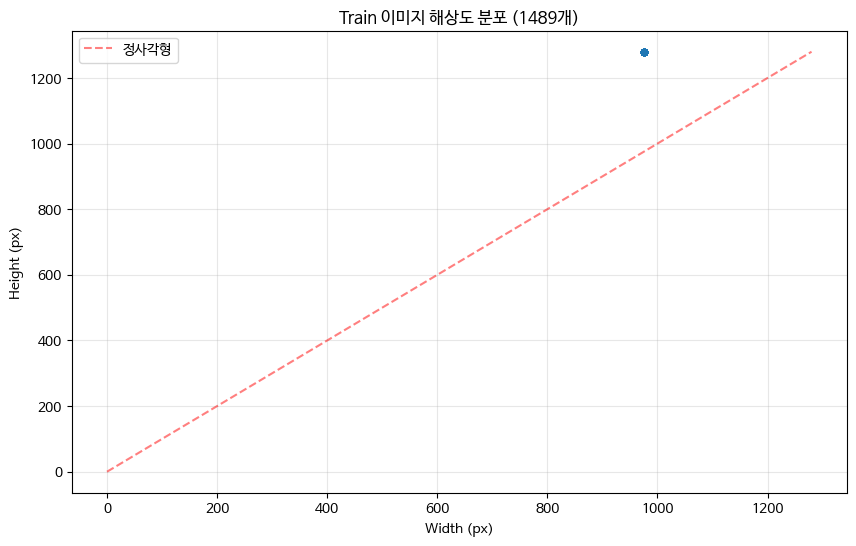

📝 train 이미지 해상도 종합결과: 976 X 1280
📝 train 이미지 평균 해상도: 976.0X1280.0


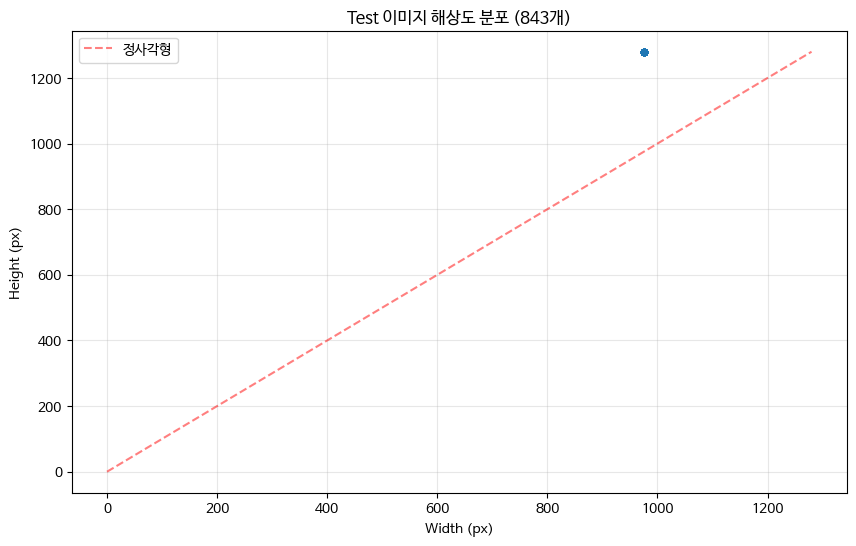

📝 test 이미지 해상도 종합결과: 976 X 1280
📝 test 이미지 평균 해상도: 976.0X1280.0


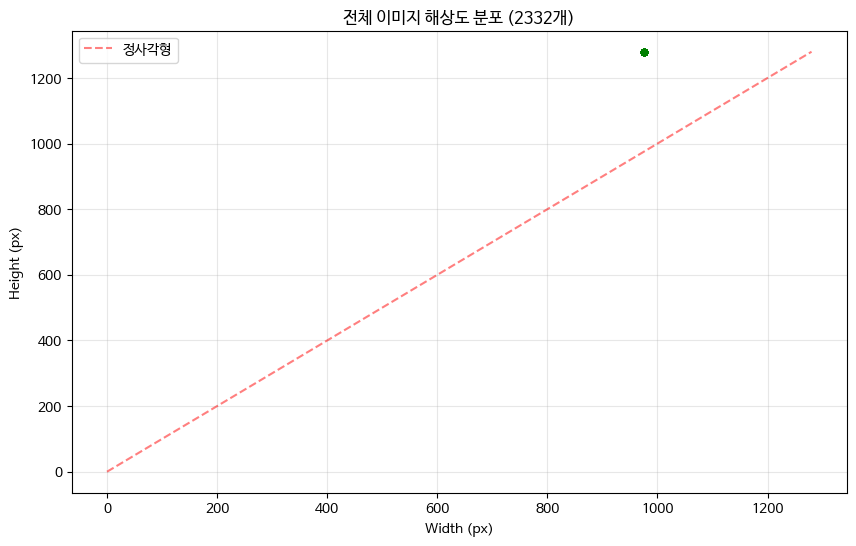

🔍 train 이미지의 채널정보를 분석합니다.


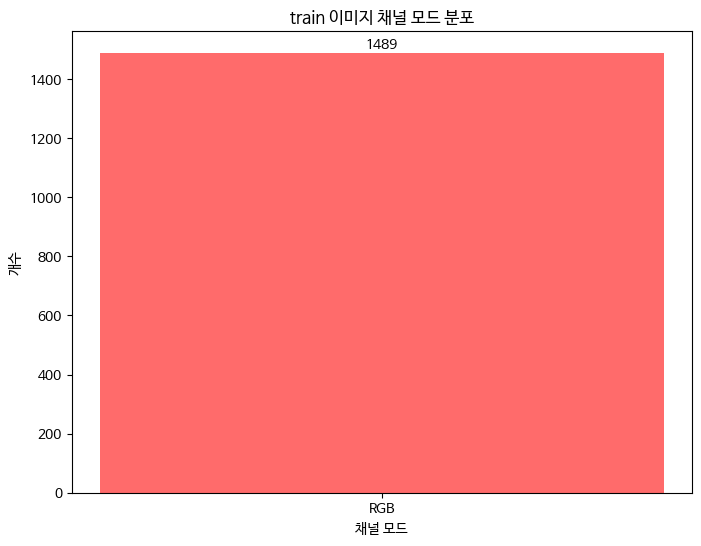

🔍 test 이미지의 채널정보를 분석합니다.


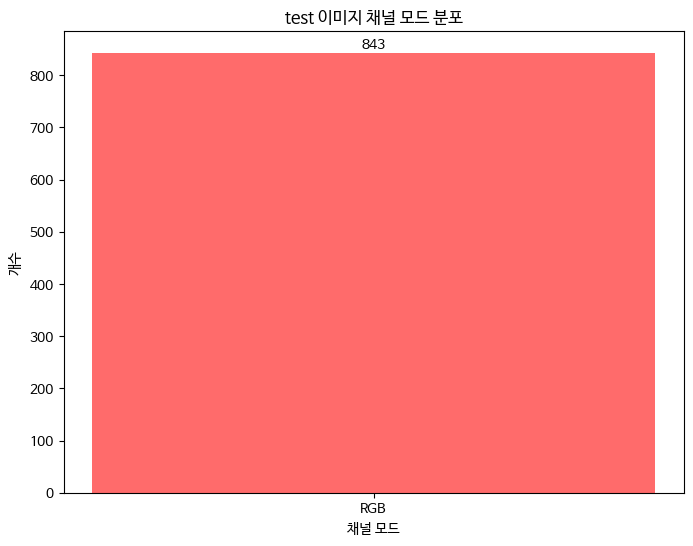

🔍 train 이미지 파일 크기 분포


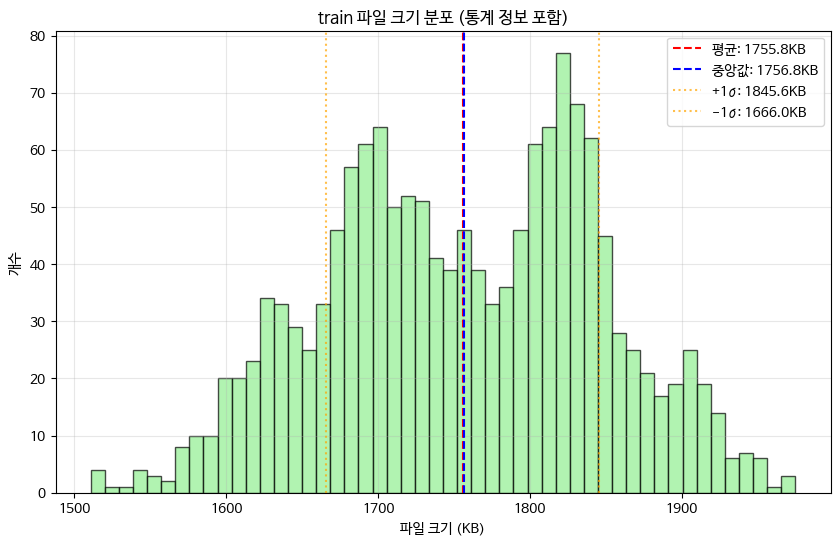

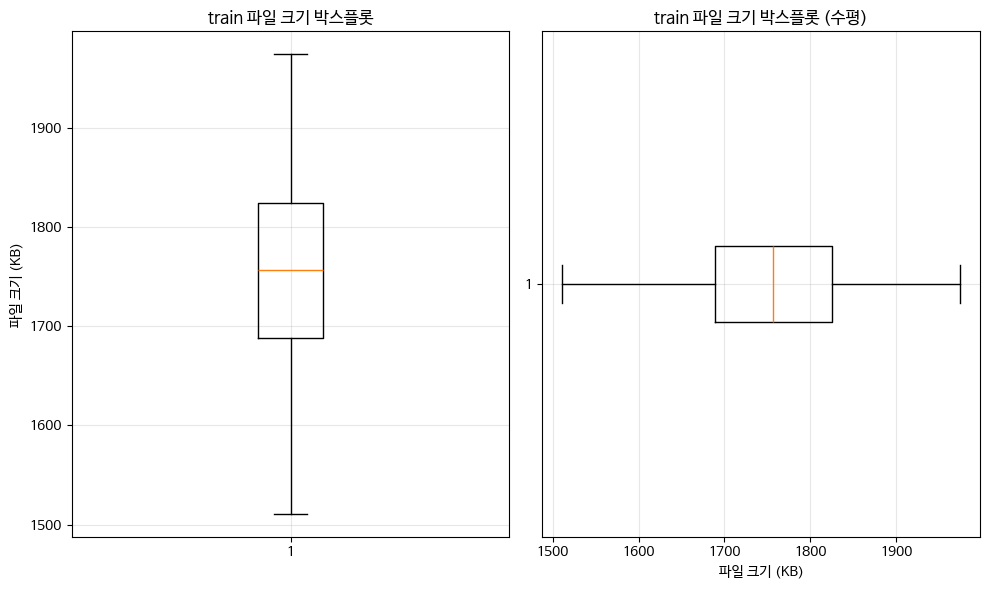

  - 📊 평균 파일 크기: 1755.8KB
  - 📊 파일 크기 범위: 1510.9KB ~ 1974.6KB
🔍 test 이미지 파일 크기 분포


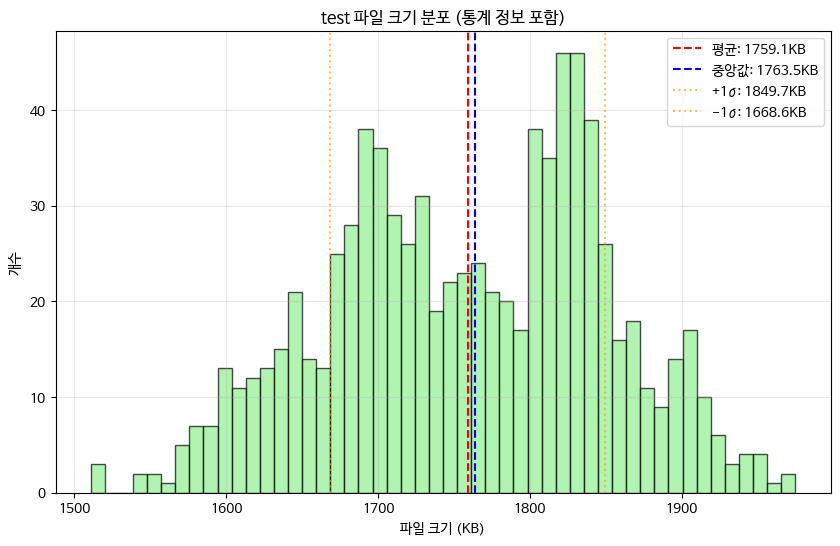

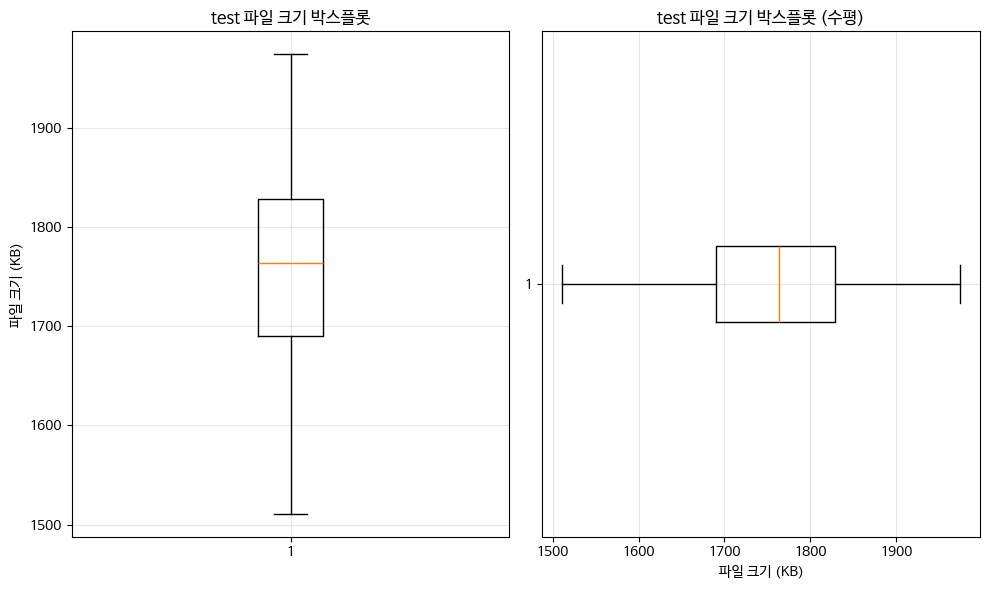

  - 📊 평균 파일 크기: 1759.1KB
  - 📊 파일 크기 범위: 1510.9KB ~ 1974.6KB

📝 Annotation JSON 샘플 분석 (3개)

🔍 샘플 1: K-001900-016548-018110-021026_0_2_0_2_75_000_200.json
   경로: K-001900-016548-018110-021026_json/K-001900/K-001900-016548-018110-021026_0_2_0_2_75_000_200.json
   📊 JSON 구조:
      타입: <class 'dict'>
      키들: ['images', 'type', 'annotations', 'categories']
         images: 리스트 (1개)
            첫 요소 키: ['file_name', 'width', 'height', 'imgfile', 'drug_N', 'drug_S', 'back_color', 'drug_dir', 'light_color', 'camera_la', 'camera_lo', 'size', 'dl_idx', 'dl_mapping_code', 'dl_name', 'dl_name_en', 'img_key', 'dl_material', 'dl_material_en', 'dl_custom_shape', 'dl_company', 'dl_company_en', 'di_company_mf', 'di_company_mf_en', 'item_seq', 'di_item_permit_date', 'di_class_no', 'di_etc_otc_code', 'di_edi_code', 'chart', 'drug_shape', 'thick', 'leng_long', 'leng_short', 'print_front', 'print_back', 'color_class1', 'color_class2', 'line_front', 'line_back', 'img_regist_ts', 'form_code_name', 'mark_co

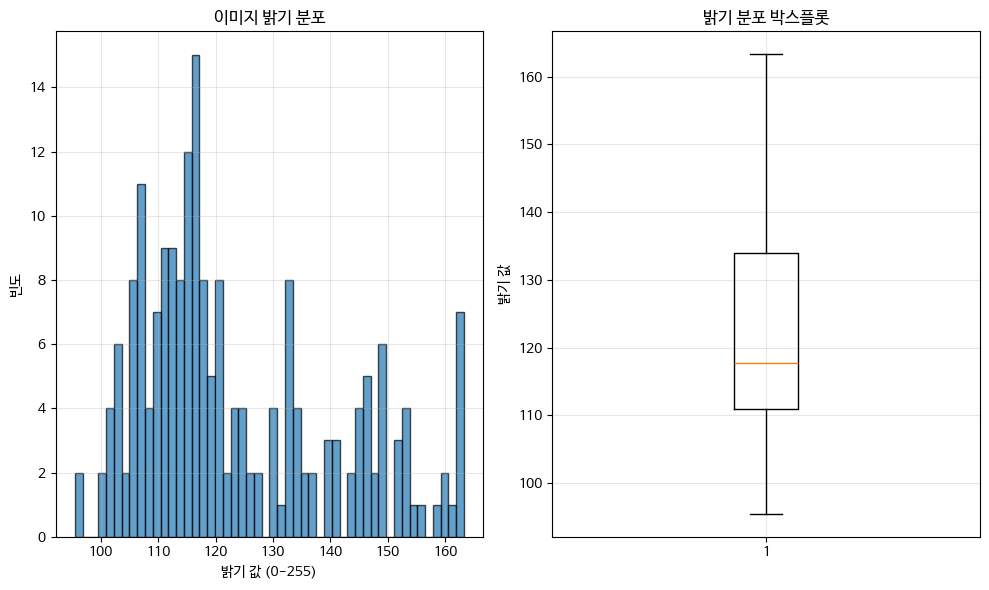

밝기 통계:
평균: 123.62
표준편차: 17.15
최솟값: 95.50
최댓값: 163.28
중앙값: 117.67

3. RGB 분포 분석
------------------------------
RGB 분석: 100개 이미지 처리
성공적으로 분석된 이미지: 100개


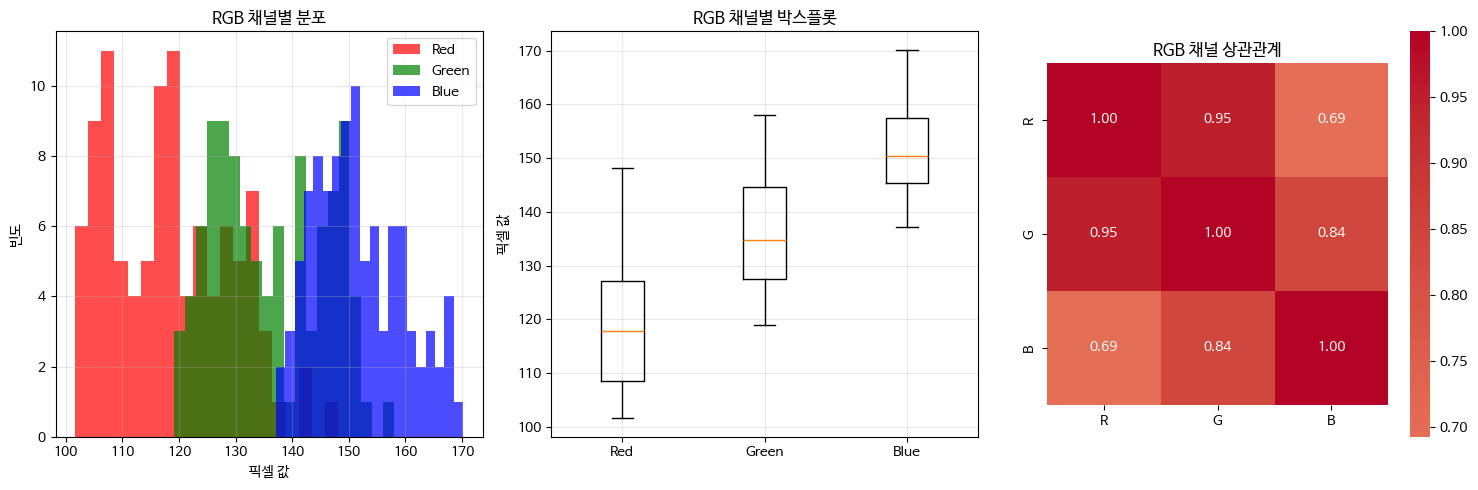

R 채널 통계:
  평균: 118.56
  표준편차: 10.80
  최솟값: 101.60
  최댓값: 148.13

G 채널 통계:
  평균: 136.00
  표준편차: 9.76
  최솟값: 119.04
  최댓값: 158.03

B 채널 통계:
  평균: 151.60
  표준편차: 7.83
  최솟값: 137.11
  최댓값: 170.19


4. 품질 이슈 이미지 분석
------------------------------
너무 어두운 이미지 (< 50): 0개
너무 밝은 이미지 (> 200): 0개

📊 분석 요약
✅ Train 이미지: 1,489개
✅ Test 이미지: 843개
✅ Train annotations: 4,526개
🔗 매칭률: 100.0%

✅ 분석 완료!


In [36]:
# 실행
if __name__ == "__main__":
    print("💡 사용법:")
    print("1. DATA_PATH 변수를 실제 경로로 수정")
    print("2. quick_analysis('경로') 직접 실행")

    # 경로 직접 지정해서 실행
    data_path = "data/"
    results = quick_dataset_analysis(data_path)

## 결과 보고서

### 1. 📝 파일 구조 및 파일 개수
파일 구조의 예시는 다음과 같다.__핵심은 복잡한 annotation 파일 구조__이다. 여러 폴더를 경유해서 찾아야 하기 때문에 불러오는 과정이 복잡하고 어려워진다.
```
data/
├─ test_images/
│  ├─ 989.png
│  ├─ 990.png
│  └─ 991.png
├─ train_images/
│  ├─ K-003544-010221-016551-027926_0_2_0_2_70_000_200.png
│  ├─ K-003544-010221-016551-027926_0_2_0_2_75_000_200.png
│  └─ K-003544-010221-016551-027926_0_2_0_2_90_000_200.png
└─ train_annotations/
   └─ K-003544-010221-016551-027926_json/
      ├─ K-003544/
      │  ├─ K-003544-010221-016551-027926_0_2_0_2_75_000_200.json
      │  └─ K-003544-010221-016551-027926_0_2_0_2_90_000_200.json
      ├─ K-010221/
      │  ├─ K-003544-010221-016551-027926_0_2_0_2_70_000_200.json
      │  └─ ...
      └─ K-016551/
         └─ ...

```
파일 개수는 다음과 같았다.  
- Train 이미지: 1,489개
- Test 이미지: 843개
- 📝 총 JSON 파일: 4,526개

JSON파일이 없는 train 이미지는 없었으며 전처리과정은 필요 없겠다.       
__파일 매치 결과__      
🖼️  이미지 파일: 1,489개        
📝 JSON 파일: 1,489개       
✅ 매칭됨: 1,489개      
🖼️  이미지만 있음: 0개      
📝 JSON만 있음: 0개     

### 2. 📝 세부 파일 탐색
파일의 해상도, 크기, 이미지 채널 및 모드를 탐색해보았고, 결론적으로 __train, test데이터 모두 976X1280의 해상도, RGB모드의 3채널 이미지 이다.__ 추가로 이미지 크기로 인한 전처리 과정은 불필요 할 것으로 잠정 결론 지을 수 있겠다.

train 이미지의 파일크기는 다음과 같다.
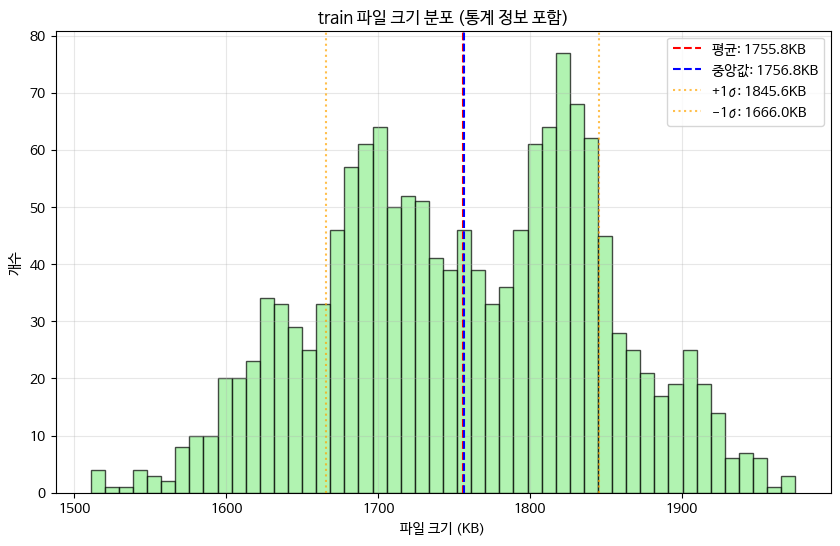
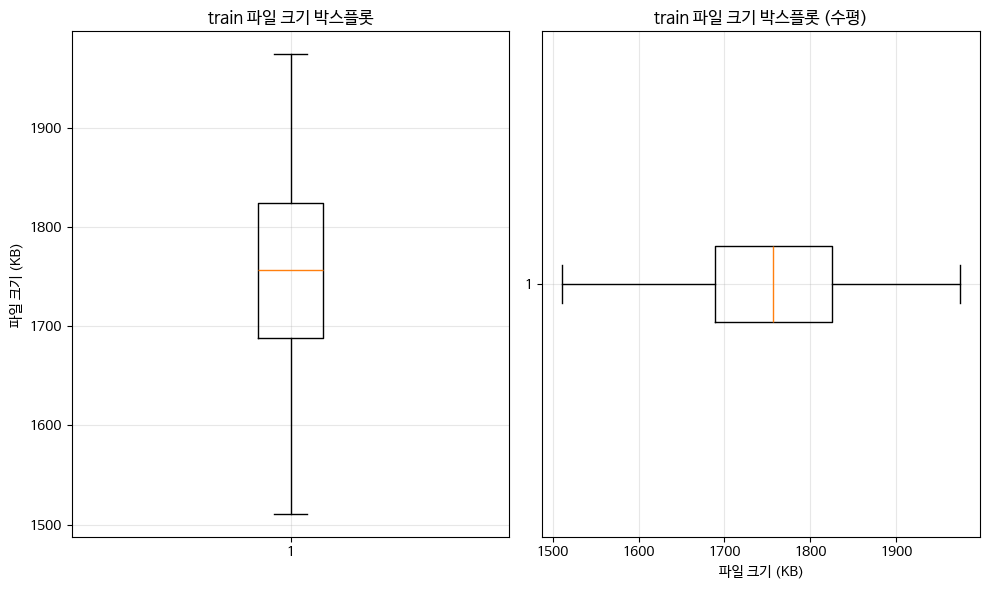
- 평균 파일 크기: 1755.8KB
- 파일 크기 범위: 1510.9KB ~ 1974.6KB

test 이미지는 다음과 같다.
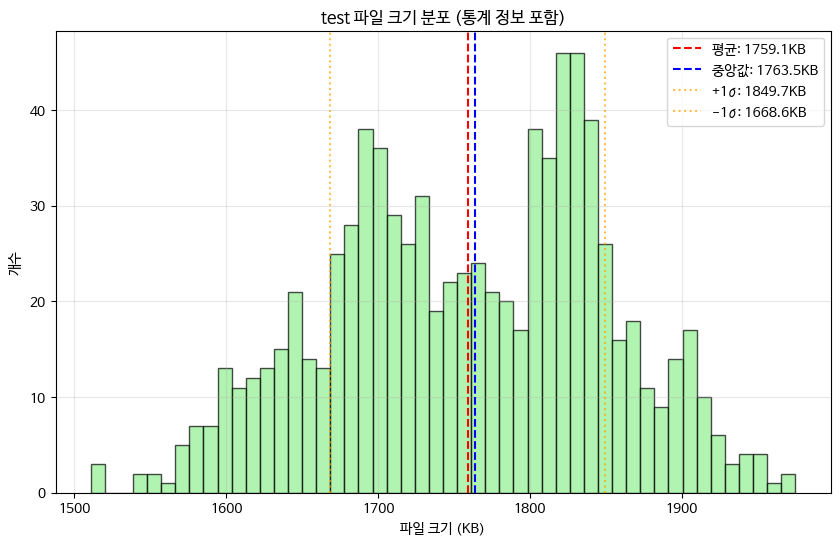
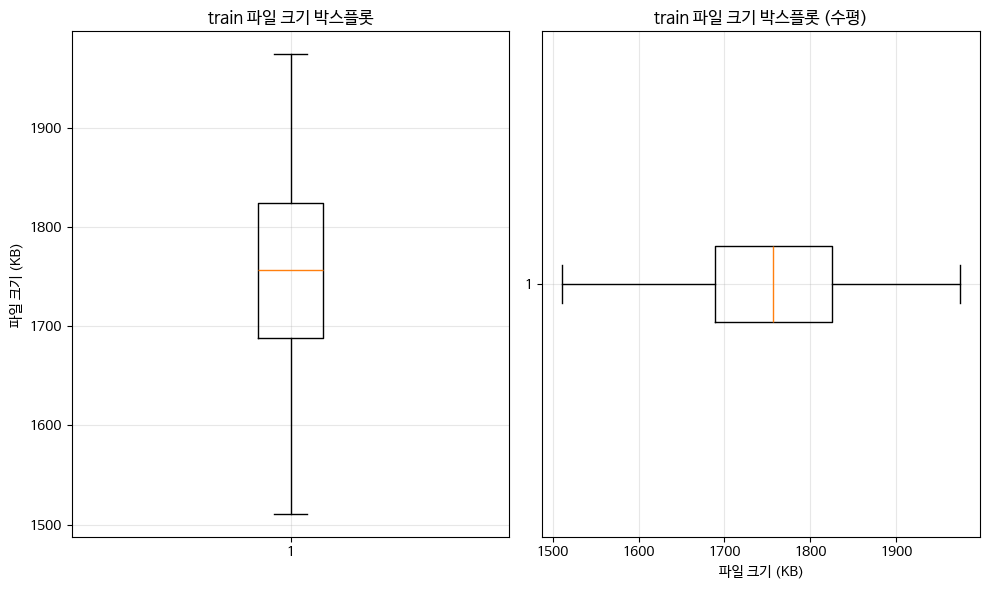
- 평균 파일 크기: 1759.1KB
- 파일 크기 범위: 1510.9KB ~ 1974.6KB

**파일 크기 분포도 거의 동일하다.**

### 3. 📝 Annotation JSON 샘플 분석
JSON 파일은 3개의 샘플데이터를 활용해 어떤 필드들이 있고 무엇이 중요한지 분석 해보았다.         
📐 바운딩박스 관련 필드들: ['type']     
   → 객체 위치/크기 정보 포함       
🏷️  클래스/카테고리 관련 필드들: ['type']       
   → 알약 종류/분류 정보 포함       
📍 키포인트 관련 필드 없음      
🎭 세그멘테이션 관련 필드 없음

📋 필드별 데이터 타입 요약:
- annotations: ['list']
- categories: ['list']
- images: ['list']
- type: ['str']

✅ 필수 필드 체크:      
   발견된 필수 정보: 위치 정보, 분류 정보
   → 기본적인 객체 탐지/분류 작업 가능

### (참고) Annotations 파일 구조 분석
3개의 샘플 데이터 폴더로 구조 분석을 했다.
📁 1단계 폴더: 498개

🔍 K-001900-016548-018110-021026_json/
- 📁 하위 폴더: 4개
- 📝 JSON 파일: 10개
- 📋 하위 폴더명 샘플: ['K-001900', 'K-016548', 'K-021026', 'K-018110']
    - K-001900: 3개 JSON
    - K-016548: 3개 JSON
    - K-021026: 2개 JSON

🔍 K-001900-016548-018110-029451_json/
- 📁 하위 폴더: 4개
- 📝 JSON 파일: 10개
- 📋 하위 폴더명 샘플: ['K-001900', 'K-016548', 'K-018110', 'K-029451']
    - K-001900: 3개 JSON
    - K-016548: 3개 JSON
    - K-018110: 2개 JSON

🔍 K-001900-016548-018110-031705_json/
- 📁 하위 폴더: 4개
- 📝 JSON 파일: 11개
- 📋 하위 폴더명 샘플: ['K-001900', 'K-016548', 'K-018110', 'K-031705']
    - K-001900: 2개 JSON
    - K-016548: 3개 JSON
    - K-018110: 3개 JSON

### 참고용train/test데이터 단일 해상도, 채널 시각화

#### 해상도
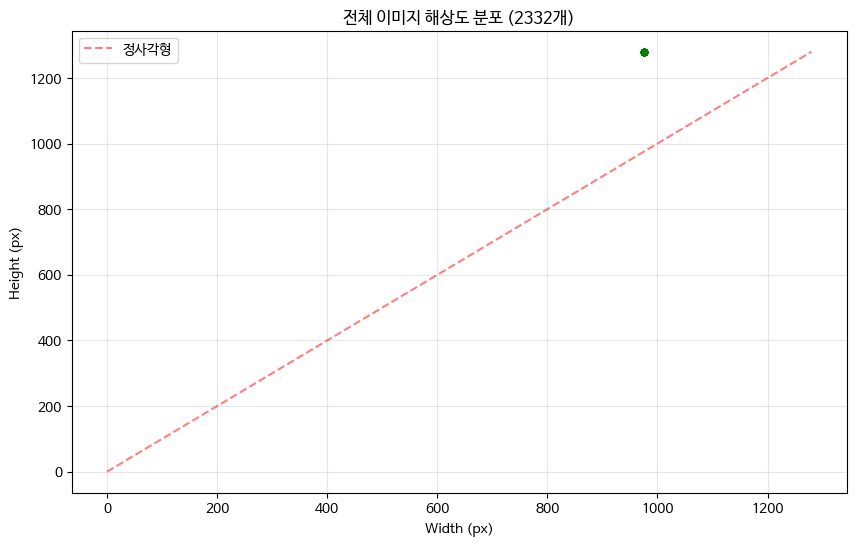

#### 채널, 모드
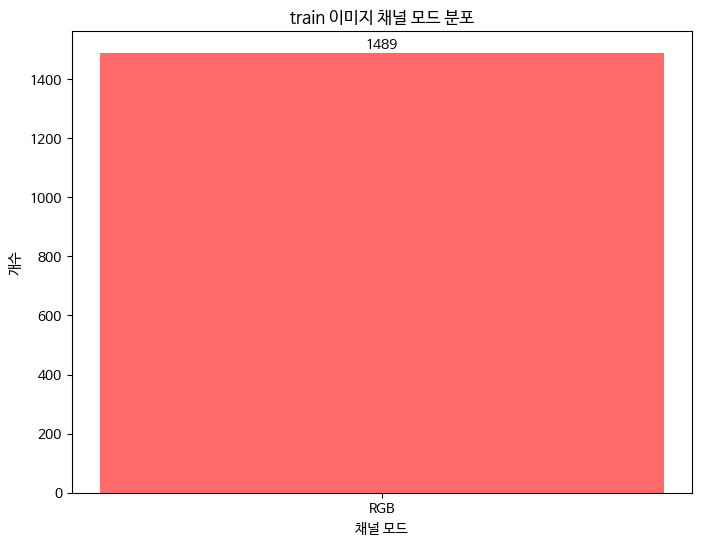
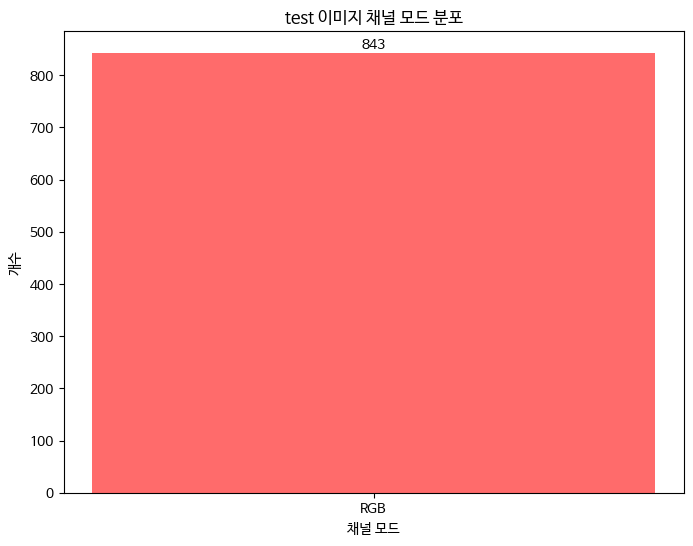

### 샘플 데이터 출력

#### train
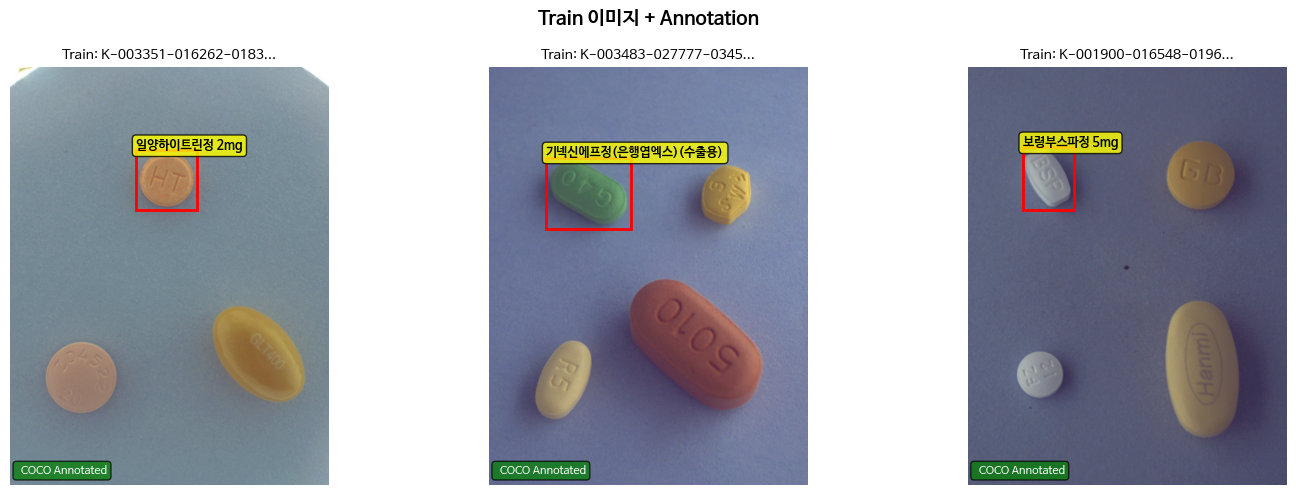

#### test
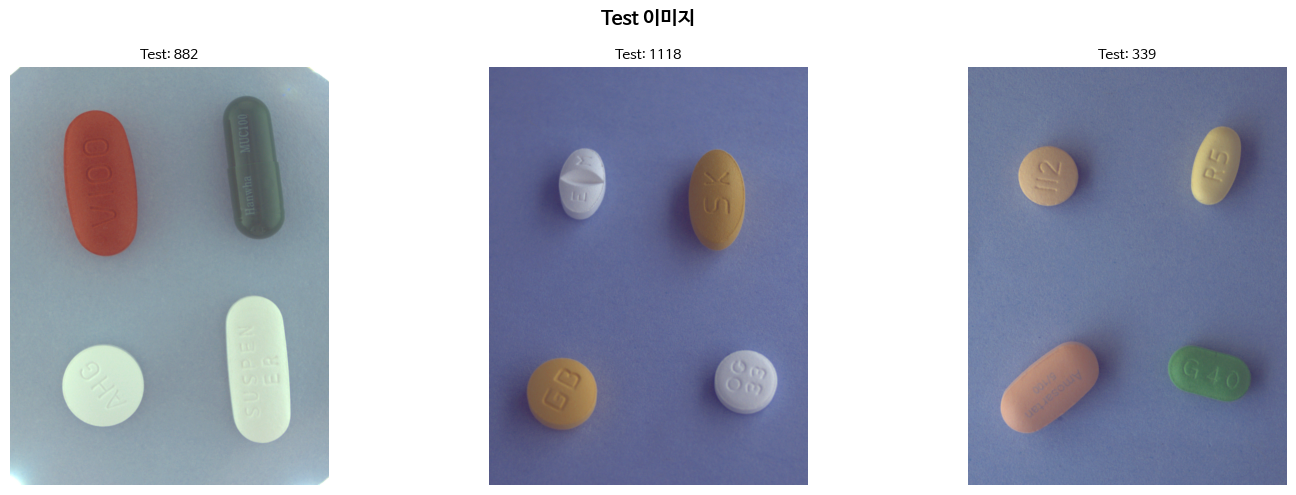

## 깃허브 업로드용 코드

In [37]:
# 전역 설정 (권장) - 이 Colab 세션에서 계속 사용
!git config --global user.name "Dongjin-1203"
!git config --global user.email "hambur1203@gmail.com"

In [39]:
!git add .

In [40]:
!git commit -m "EDA: 이미지 심층 분석, RGB, 밝기 분석 추가"

[main 166fb4d] EDA: 이미지 심층 분석, RGB, 밝기 분석 추가
 2 files changed, 2 insertions(+), 2 deletions(-)
 rewrite model/notebooks/ETL_test_YOLOv8.ipynb (72%)
 rewrite notebooks/data_EDA.ipynb (76%)


In [41]:
!git pull origin main

From https://github.com/Dongjin-1203/Codeit_AI_4th_Drug_image_CV_project
 * branch            main       -> FETCH_HEAD
Already up to date.


In [42]:
!git push origin main

Enumerating objects: 13, done.
Counting objects: 100% (13/13), done.
Delta compression using up to 2 threads
Compressing objects: 100% (5/5), done.
Writing objects: 100% (7/7), 73.78 KiB | 312.00 KiB/s, done.
Total 7 (delta 4), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (4/4), completed with 4 local objects.
To https://github.com/Dongjin-1203/Codeit_AI_4th_Drug_image_CV_project.git
   d544061..166fb4d  main -> main
